In [1]:
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
import torch

In [18]:
def load_ludb_data(data_path, lead):
    records = []
    annotations = []
    
    lead_names = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
    
    for record_name in sorted(os.listdir(data_path)):
        if record_name.endswith(".dat"):
            record_id = record_name[:-4]
            
            try:
                record = wfdb.rdrecord(os.path.join(data_path, record_id), channels=[lead])
                records.append(record.p_signal[:, 0])
                
                annotation = wfdb.rdann(os.path.join(data_path, record_id), lead_names[lead])
                annotations.append(annotation)
            except FileNotFoundError:
                print(f"No record or annotation file found for {record_id}")
                continue

    return records, annotations







In [54]:
data_path = "/Users/aman/Downloads/ludb/data"
lead = 0
pecg_data, ecg_annotations = load_ludb_data(data_path, lead)


In [55]:
from scipy.signal import butter, filtfilt

def bandpass_filter(ecg_signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_ecg = filtfilt(b, a, ecg_signal)
    return filtered_ecg

def normalize_ecg(ecg_signal):
    normalized_ecg = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)
    return normalized_ecg

# Example usage
lowcut = 0.5  # Low frequency cutoff in Hz
highcut = 50  # High frequency cutoff in Hz
fs = 500  # Sampling frequency in Hz

In [56]:
def process_all_ecg_signals(all_lead_II_ecgs, lowcut, highcut, fs):
    processed_ecgs = []
    for lead_II_signal in all_lead_II_ecgs:
        # Apply bandpass filter
        filtered_ecg = bandpass_filter(lead_II_signal, lowcut, highcut, fs)
        
        # Normalize the ECG signal
        normalized_ecg = normalize_ecg(filtered_ecg)
        
        processed_ecgs.append(normalized_ecg)
    return processed_ecgs

# Example usage
lowcut = 0.5  # Low frequency cutoff in Hz
highcut = 50  # High frequency cutoff in Hz
fs = 500  # Sampling frequency in Hz

# Process all Lead II ECG signals
ecg_data = process_all_ecg_signals(pecg_data, lowcut, highcut, fs)

In [57]:
def create_single_mask(annotation, sig_len):
    mask = np.zeros(sig_len)
    wave_start, wave_category = None, None

    for i, symbol in enumerate(annotation.symbol):
        if symbol == "(":
            wave_start = annotation.sample[i]
        elif symbol == "p":
            if wave_start is not None:
                wave_category = 1
        elif symbol == "N":
            if wave_start is not None:
                wave_category = 2
        elif symbol == "t":
            if wave_start is not None:
                wave_category = 3
        elif symbol == ")":
            wave_end = annotation.sample[i]
            if wave_start is not None and wave_category is not None:
                mask[wave_start:wave_end] = wave_category
            wave_start, wave_category = None, None

    return mask

ecg_single_masks = [create_single_mask(ann, len(sig)) for sig, ann in zip(ecg_data, ecg_annotations)]





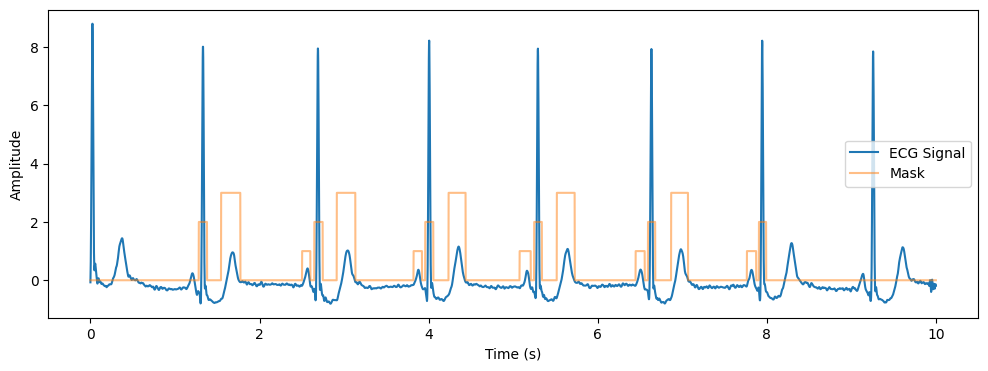

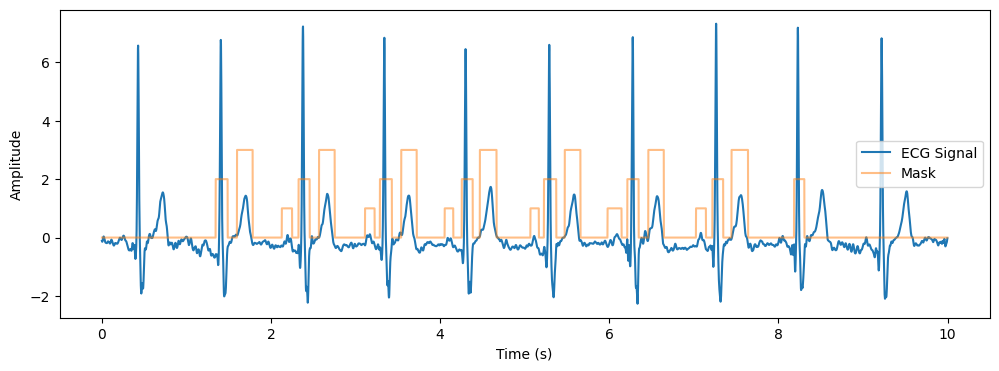

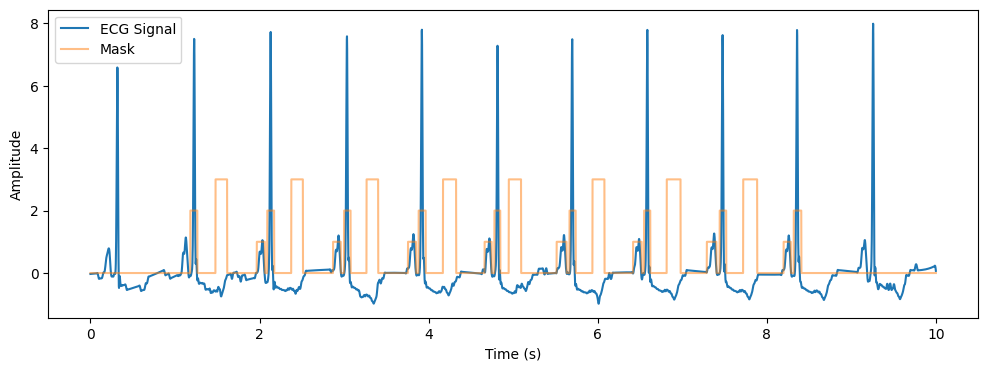

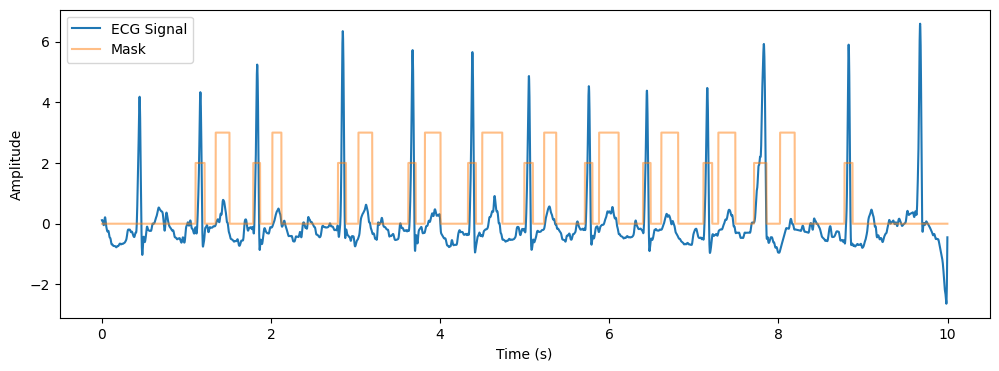

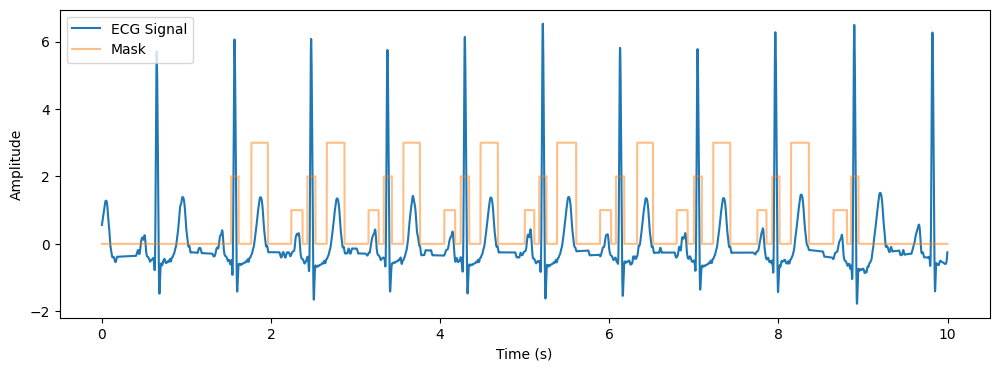

In [58]:
fs= 500
def plot_ecg_with_single_mask(ecg_signal, mask, duration, fs):
    time = np.arange(0, duration, 1/fs)
    
    plt.figure(figsize=(12, 4))
    
    plt.plot(time, ecg_signal, label="ECG Signal")
    plt.plot(time, mask, label="Mask", alpha=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Plot a few ECG signals with their corresponding single masks
num_signals_to_plot = 5
duration = len(ecg_data[0]) / fs

for i in range(num_signals_to_plot):
    plot_ecg_with_single_mask(ecg_data[i], ecg_single_masks[i], duration, fs)



In [59]:
def zero_unannotated_regions(signal, mask):
    # Find the start and end indices of the annotated region
    start_idx = np.argmax(mask > 0)
    end_idx = len(mask) - np.argmax(mask[::-1] > 0)

    # Set the values before and after the annotated region to zero
    signal[:start_idx] = 0
    signal[end_idx:] = 0

    return signal

In [60]:
ecg_zeroed_data = []

for signal, mask in zip(ecg_data, ecg_single_masks):
    zeroed_signal = zero_unannotated_regions(signal, mask)
    ecg_zeroed_data.append(zeroed_signal)

In [61]:
import matplotlib.pyplot as plt

def plot_signal_and_mask(signal, mask):
    fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

    ax[0].plot(signal)
    ax[0].set_title("Trimmed ECG Signal")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(mask)
    ax[1].set_title("ECG Mask")
    ax[1].set_xlabel("Time (samples)")
    ax[1].set_ylabel("Wave Category")

    plt.tight_layout()
    plt.show()


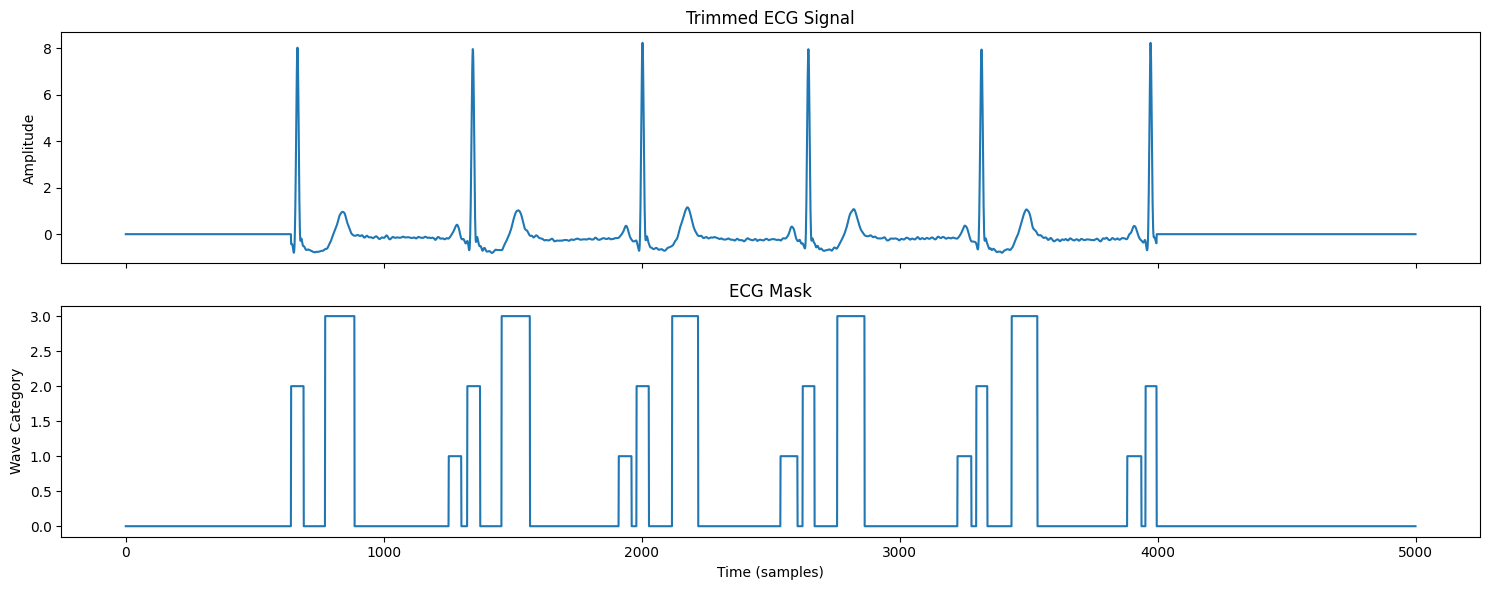

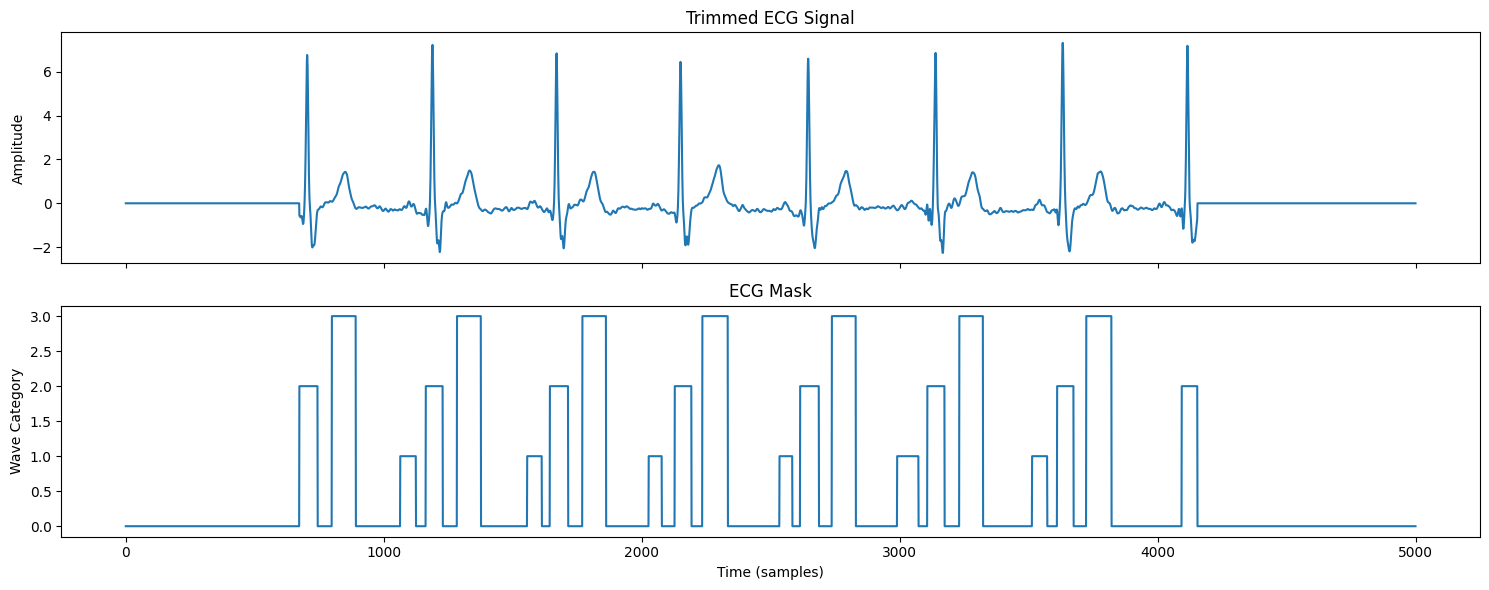

In [62]:
num_signals_to_plot = 2

for i in range(num_signals_to_plot):
    plot_signal_and_mask(ecg_zeroed_data[i], ecg_single_masks[i])


In [18]:
record_id = '1'
lead = 1
lead_name = lead_map[lead]

record = wfdb.rdrecord(os.path.join(data_path, record_id))
lead_idx = record.sig_name.index(lead_name)

selected_record = wfdb.rdrecord(os.path.join(data_path, record_id), channels=[lead_idx])
print(selected_record.__dict__)




{'record_name': '1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': ['<age>: 51', '<sex>: F', '<diagnoses>:', 'Rhythm: Sinus bradycardia.', 'Electric axis of the heart: left axis deviation.', 'Left ventricular hypertrophy.', 'Left ventricular overload.', 'Non-specific repolarization abnormalities: posterior wall.'], 'sig_name': ['i'], 'p_signal': array([[-0.07342657],
       [-0.02855478],
       [ 0.01689977],
       ...,
       [-0.04079254],
       [-0.03671329],
       [-0.04195804]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['1.dat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1716.0], 'baseline': [6], 'units': ['mV'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [-120], 'checksum': [-32198], 'block_size': [0]}


In [21]:
annotation_ext = None
for ext in ['i']:   
    if os.path.exists(os.path.join(data_path, f"{record_id}.{ext}")):
        annotation_ext = ext
        break

if annotation_ext is not None:
    annotation = wfdb.rdann(os.path.join(data_path, record_id), annotation_ext)
    print(annotation.__dict__)
else:
    print(f"No annotation file found for {record_id}")


{'record_name': '1', 'extension': 'i', 'sample': array([ 641,  664,  690,  773,  840,  887, 1252, 1282, 1301, 1324, 1344,
       1374, 1457, 1519, 1567, 1911, 1938, 1961, 1980, 2002, 2028, 2118,
       2176, 2219, 2538, 2581, 2604, 2624, 2645, 2670, 2758, 2820, 2864,
       3224, 3252, 3278, 3297, 3316, 3340, 3434, 3491, 3534, 3882, 3908,
       3937, 3953, 3971, 3996]), 'symbol': ['(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), 'num': array([0, 0, 0

In [63]:
from torch.utils.data import DataLoader, Dataset
class ECGDataset(Dataset):
    def __init__(self, signals, masks):
        self.signals = signals
        self.masks = masks

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        mask = self.masks[idx]

        # Add channel dimension to the signal
        signal = signal.unsqueeze(0)

        return signal.float(), mask.long()



In [64]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Convert lists to arrays for train_test_split
ecg_zeroed_data = np.array(ecg_zeroed_data)
ecg_single_masks = np.array(ecg_single_masks)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ecg_zeroed_data, ecg_single_masks, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset = ECGDataset(X_train_tensor, y_train_tensor)
test_dataset = ECGDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [65]:
for inputs, labels in train_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", labels.shape)
    break


Input shape: torch.Size([32, 1, 5000])
Target shape: torch.Size([32, 5000])


In [66]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.middle = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.output_conv = nn.Conv1d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        x = self.output_conv(x)

        return x


class UNetWithPrint(UNet):
    def __init__(self, in_channels, out_channels):
        super(UNetWithPrint, self).__init__(in_channels, out_channels)

    def forward(self, x):
        print("Input shape:", x.shape)

        x = self.encoder(x)
        print("Shape after encoder:", x.shape)
        
        x = self.middle(x)
        print("Shape after middle:", x.shape)

        x = self.decoder(x)
        print("Shape after decoder:", x.shape)

        x = self.output_conv(x)
        print("Output shape:", x.shape)

        return x







In [67]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.encoder4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Middle
        self.middle = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.Conv1d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.decoder2 = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.decoder3 = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.decoder4 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Final Classifier
        self.output_conv = nn.Conv1d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        x_middle = self.middle(x4)

        x = self.decoder1(x_middle)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        x = self.output_conv(x)
        return x


In [68]:
model = UNet(1, 4)

In [69]:
print(model)

UNet(
  (encoder1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (middle): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), paddin

In [71]:
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Train the model
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f'Training Loss: {train_loss:.4f}')
    
    # Test the model
    model.eval()
    running_loss = 0.0
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item()

    test_loss = running_loss / len(test_loader)
    print(f'Test Loss: {test_loss:.4f}\n')


Epoch 1/10


100%|██████████| 5/5 [21:05<00:00, 253.07s/it]


Training Loss: 1.1865


100%|██████████| 2/2 [01:42<00:00, 51.37s/it]


Test Loss: 0.9318

Epoch 2/10


100%|██████████| 5/5 [21:03<00:00, 252.78s/it]


Training Loss: 0.8666


100%|██████████| 2/2 [01:43<00:00, 51.69s/it]


Test Loss: 0.7347

Epoch 3/10


100%|██████████| 5/5 [21:10<00:00, 254.06s/it]


Training Loss: 0.7890


100%|██████████| 2/2 [01:43<00:00, 51.67s/it]


Test Loss: 0.7608

Epoch 4/10


100%|██████████| 5/5 [21:01<00:00, 252.40s/it]


Training Loss: 0.7535


100%|██████████| 2/2 [01:42<00:00, 51.19s/it]


Test Loss: 0.6793

Epoch 5/10


100%|██████████| 5/5 [20:57<00:00, 251.58s/it]


Training Loss: 0.6890


100%|██████████| 2/2 [01:42<00:00, 51.36s/it]


Test Loss: 0.6682

Epoch 6/10


100%|██████████| 5/5 [20:53<00:00, 250.72s/it]


Training Loss: 0.6579


100%|██████████| 2/2 [01:41<00:00, 50.84s/it]


Test Loss: 0.6237

Epoch 7/10


100%|██████████| 5/5 [20:49<00:00, 249.89s/it]


Training Loss: 0.6357


100%|██████████| 2/2 [01:42<00:00, 51.20s/it]


Test Loss: 0.6093

Epoch 8/10


100%|██████████| 5/5 [20:56<00:00, 251.34s/it]


Training Loss: 0.6173


100%|██████████| 2/2 [01:44<00:00, 52.18s/it]


Test Loss: 0.5882

Epoch 9/10


100%|██████████| 5/5 [20:52<00:00, 250.48s/it]


Training Loss: 0.5993


100%|██████████| 2/2 [01:41<00:00, 50.94s/it]


Test Loss: 0.5825

Epoch 10/10


100%|██████████| 5/5 [20:50<00:00, 250.03s/it]


Training Loss: 0.5904


100%|██████████| 2/2 [01:42<00:00, 51.09s/it]

Test Loss: 0.5632



In [72]:
torch.save(model.state_dict(), "/Users/aman/Downloads/ecg/unet_filt")
model = UNet(1, 4)  
model.load_state_dict(torch.load("/Users/aman/Downloads/ecg/unet_filt"))
model.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (middle): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), paddin

Signal: [0. 0. 0. ... 0. 0. 0.]
Predicted mask: [0 0 0 ... 0 0 0]


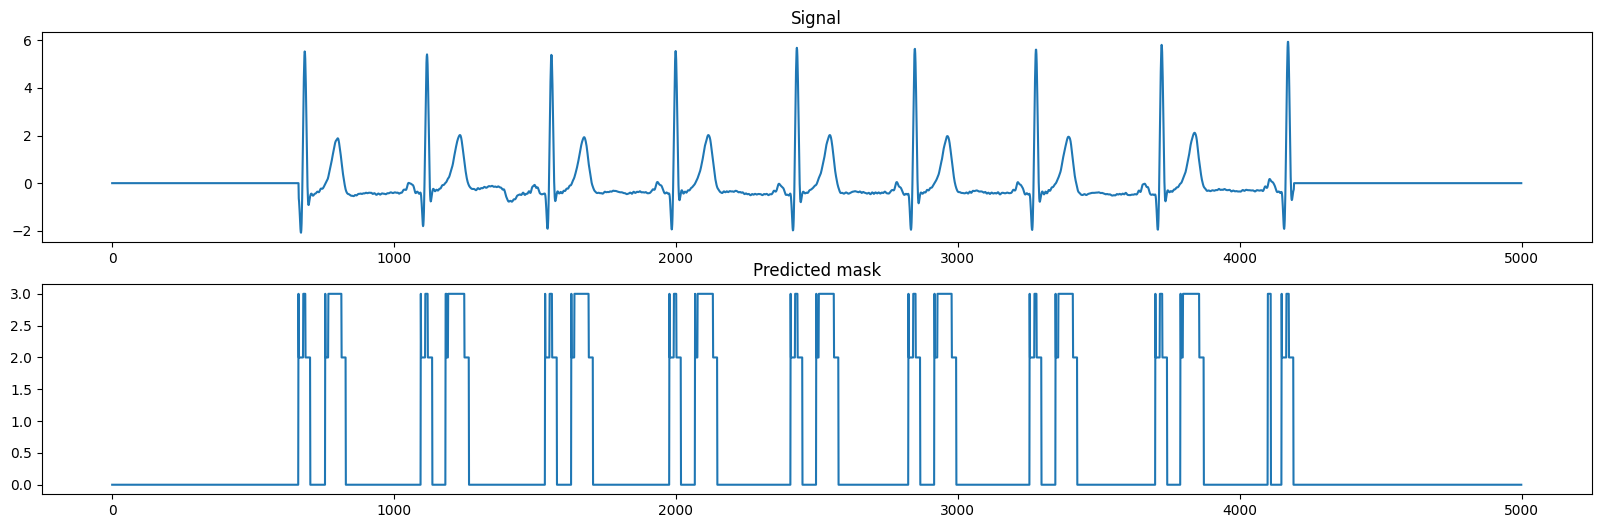

In [73]:

# Forward pass
outputs = model(inputs)  # outputs shape: (batch_size, num_classes, sequence_length)

# Compute the predicted classes
predicted_masks = torch.argmax(outputs, dim=1)  # predicted_masks shape: (batch_size, sequence_length)

# Now, let's print the first signal and its predicted mask
signal = inputs[0, 0].detach().cpu().numpy()  # convert to numpy for easier handling
predicted_mask = predicted_masks[0].detach().cpu().numpy()

# Print signal and mask
print("Signal:", signal)
print("Predicted mask:", predicted_mask)

# Plot signal and mask
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title("Signal")

plt.subplot(2, 1, 2)
plt.plot(predicted_mask)
plt.title("Predicted mask")

plt.show()


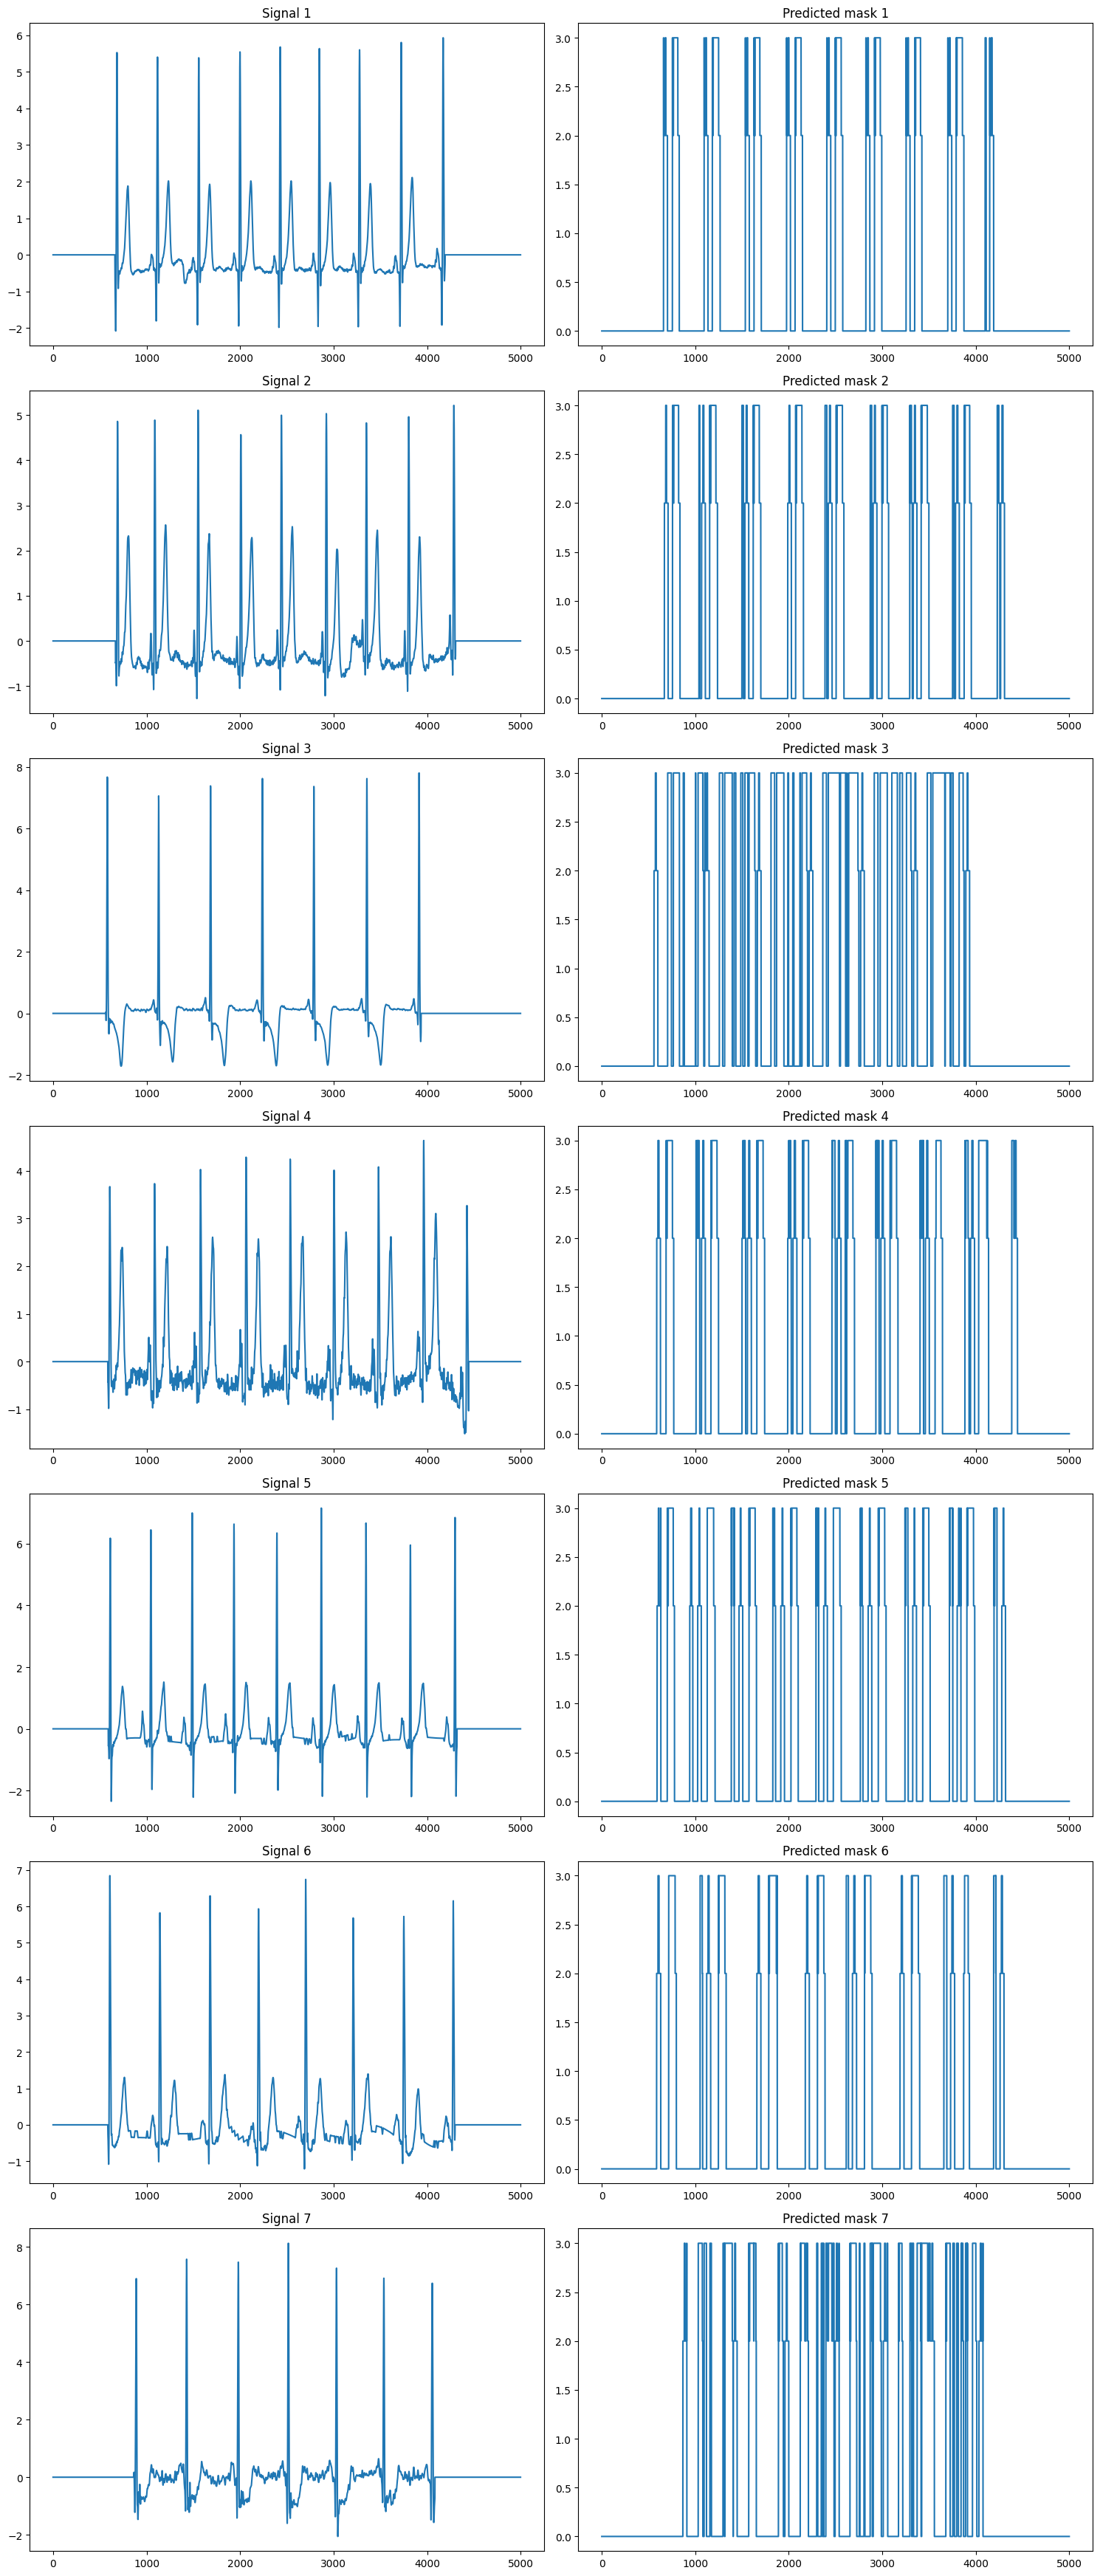

In [74]:
n = 7 # number of samples to plot

# Create a subplot for each signal and corresponding mask
fig, axs = plt.subplots(n, 2, figsize=(15, n*5))  # 2 columns for each signal and mask pair

for i in range(n):
    signal = inputs[i, 0].detach().cpu().numpy()
    predicted_mask = predicted_masks[i].detach().cpu().numpy()

    axs[i, 0].plot(signal)
    axs[i, 0].set_title(f"Signal {i+1}")

    axs[i, 1].plot(predicted_mask)
    axs[i, 1].set_title(f"Predicted mask {i+1}")

plt.tight_layout()  # adjusts subplot params so that the subplots fit into the figure area
plt.show()
